# Online Retail Project
Data file from: https://github.com/PrayagRD/Online-Customer-Segmentation/tree/main

First - install Pandas and create the Dataframe:

In [ ]:
%pip install pandas openpyxl

In [ ]:
# Load the excel file
import pandas as pd
df = pd.read_excel('Online_Retail.xlsx', engine='openpyxl')

# Display the first few rows of the dataframe
print(df.head())

In [ ]:
df.info()
# Display the number of rows and columns
    ##there are  8 columns, 541909 rows

In [ ]:
df.duplicated().sum()
# Check for duplicates in the dataframe
    # There are 5268 duplicate rows in the dataframe
    # There are now 536,641 unique rows in the dataframe

In [ ]:
# Remove duplicates
df = df.drop_duplicates()

In [ ]:
df.isnull().sum() # Check for missing values in each column
# There are 135,037 missing values in the 'CustomerID' column -- this is a about 25% of the data

In [ ]:
df.dropna(inplace=True)  # Drop null values
df.shape  # Check the shape of the dataframe after dropping nulls

In [ ]:
df['InvoiceNo'].str.startswith('C').sum()
# Check for cancelled transactions
# There are 8872 cancelled transactions in the dataset

In [ ]:
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]# Remove cancelled transactions

In [ ]:
(df['Quantity'] <= 0).sum() # Check for negative or zero quantities
    # There are no entries with negative or zero quantities

In [ ]:
(df['UnitPrice'] <= 0).sum() # Check for negative or zero unit prices
    # There are 40 entries with zero unit price

In [ ]:
df = df[df['UnitPrice'] > 0]  # Remove entries with zero unit price

## RFM (Recency, Frequency, Monetary) analysis 


In [ ]:
import datetime as dt

snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

In [ ]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice'] # Create a new column for total price

In [ ]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': 'sum'                                       # Monetary
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']


In [ ]:
rfm.describe()  # Describe the RFM metrics

In [ ]:
# Display the histograms for RFM features

import matplotlib.pyplot as plt
import seaborn as sns

rfm.hist(bins=30, figsize=(12, 6))
plt.suptitle('RFM Feature Distributions')
plt.show() 

In [ ]:
# RFM scoring
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])  # Lower recency = better
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])

# Combine into a single score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Note: The RFM_Score is a string, e.g., '432' means high recency, low frequency, and high monetary value.
# While 444 means high recency, frequency, and monetary value. And 111 means low recency, frequency, and monetary value.

In [40]:
# Display the RFM scores for the best customers
rfm[rfm['RFM_Score'] == '444'].head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
CustomerID,,,,,,,
12347.0,2,7,4310.00,4,4,4,444
12362.0,3,10,5226.23,4,4,4,444
12388.0,16,6,2780.66,4,4,4,444
12417.0,3,9,3649.10,4,4,4,444
12423.0,1,8,1859.31,4,4,4,444


## K-Means Clustering

In [42]:
# First, normalize the RFM scores to a 0-1 scale

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

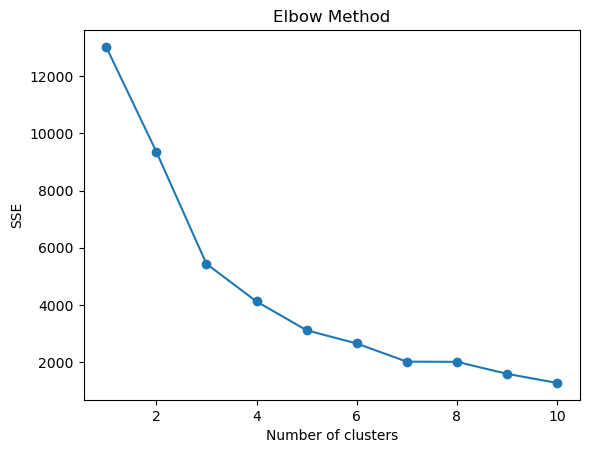

In [43]:
# Second, use the elbow method to determine the optimal number of clusters
from sklearn.cluster import KMeans

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()


In [44]:
# Third, fit the KMeans model with the optimal number of clusters
kmeans = KMeans(n_clusters=4, random_state=1)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


In [ ]:
# Get basic statistics for each cluster

# Remember a low recency score indicates a recent purchase, while a high monetary score indicates high spending.
# Cluster 0: Moderate Recency, Low Frequency, Low Monetary = Needs Attention They’ve purchased semi-recently, but spend little and purchase infrequently.
# Cluster 1: High Recency, Low Frequency, Low Monetary = Lost Customers Haven’t purchased in a long time, and were never very active or valuable. 
# Cluster 2: Low Recency, Moderate Frequency, Moderate Monetary = Recent Customers Just purchased, some spending/frequency — could be nurtured into loyal buyers.
# Cluster 3 : Low Recency, High Frequency, High Monetary = 	Loyal/VIP Customers	Ideal customers — active, recent, and high spenders.
rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

,Recency,Frequency,Monetary
Cluster,,,
0,42.380621,4.137429,1557.870289
1,247.215413,1.553389,555.292712
2,13.406250,34.739583,21675.436250
3,6.714286,65.428571,184080.341429


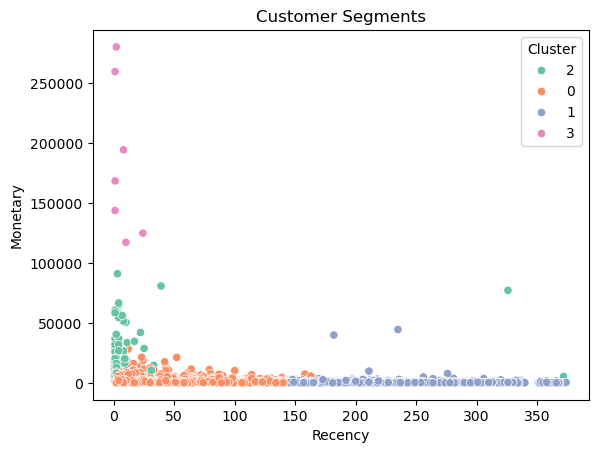

In [ ]:
# Fourth, visualize the clusters

sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='Set2')
plt.title('Customer Segments')
plt.show()

In [63]:
# Next, assign the cluster and segment label to each customer

# Need to convert the Cluster column to integer type for segment_map
rfm['Cluster'] = rfm['Cluster'].astype(int)

In [64]:
# Create a mapping for the segments based on clusters
segment_map = {
    0: 'Needs Attention',
    1: 'Lost Customers',
    2: 'Recent Customers',
    3: 'Loyal/VIP Customers'
}

rfm['Segment'] = rfm['Cluster'].map(segment_map)

In [65]:
# Apply the segment mapping to the RFM DataFrame
rfm['Segment'] = rfm['Cluster'].map(segment_map)

In [67]:
# View the cutomers in each segment
rfm.groupby('Segment').size().reset_index(name='Customer Count')
rfm.head(1-10)  # Display the first 10 rows of the RFM DataFrame with segments



,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Cluster,Segment
CustomerID,,,,,,,,,
12346.0,326,1,77183.60,1,1,4,114,2,Recent Customers
12347.0,2,7,4310.00,4,4,4,444,0,Needs Attention
12348.0,75,4,1797.24,2,3,4,234,0,Needs Attention
12349.0,19,1,1757.55,3,1,4,314,0,Needs Attention
12350.0,310,1,334.40,1,1,2,112,1,Lost Customers
...,...,...,...,...,...,...,...,...,...
18268.0,134,1,25.50,2,2,1,221,0,Needs Attention
18269.0,366,1,168.60,1,2,1,121,1,Lost Customers
18270.0,38,2,283.15,3,3,1,331,0,Needs Attention


In [ ]:
# Display summary statistics for each segment
    ## There are 7 VIP customers, 1,077 Lost customers, 96 Recent customers, and 3,158 customers that need attention
rfm.groupby('Segment').describe()

Recency                                              \
                      count        mean        std    min    25%    50%   
Segment                                                                   
Lost Customers       1077.0  247.215413  66.676757  141.0  189.0  242.0   
Loyal/VIP Customers     7.0    6.714286   8.479668    1.0    1.0    2.0   
Needs Attention      3158.0   42.380621  35.582819    1.0   14.0   31.0   
Recent Customers       96.0   13.406250  49.861403    1.0    2.0    4.0   

                                  Frequency             ...     Monetary  \
                       75%    max     count       mean  ...          75%   
Segment                                                 ...                
Lost Customers       299.0  374.0    1077.0   1.553389  ...     540.4500   
Loyal/VIP Customers    9.0   24.0       7.0  65.428571  ...  227024.0450   
Needs Attention       64.0  163.0    3158.0   4.137429  ...    1935.7175   
Recent Customers       9.0  372.0      96.0  34.739583  ...   28276.3075   

                               Cluster                                     
                           max   count mean  std  min  25%  50%  75%  max  
Segment                                                                    
Lost Customers        44534.30  1077.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  
Loyal/VIP Customers  280206.02     7.0  3.0  0.0  3.0  3.0  3.0  3.0  3.0  
Needs Attention       28337.38  3158.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
Recent Customers      91062.38    96.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0  

[4 rows x 32 columns]

## Create visuals showing customer segmentation 

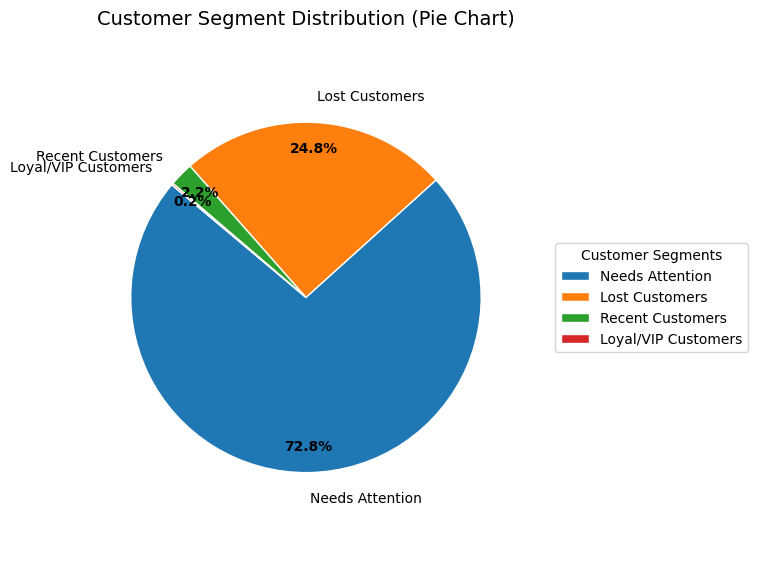

In [79]:
import matplotlib.pyplot as plt

# Count customers per segment
segment_counts = rfm['Segment'].value_counts()
labels = segment_counts.index
sizes = segment_counts.values

# Create pie chart
fig, ax = plt.subplots(figsize=(7.5, 6))
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    labeldistance=1.15,      # Push labels outside
    pctdistance=0.85,        # Push %s just outside the pie
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)

# Add legend (data key)
ax.legend(wedges, labels, title="Customer Segments", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Improve appearance
plt.setp(autotexts, size=10, weight="bold")
plt.title('Customer Segment Distribution (Pie Chart)', fontsize=14)
plt.axis('equal')  # Keep circle shape
plt.tight_layout()
plt.show()

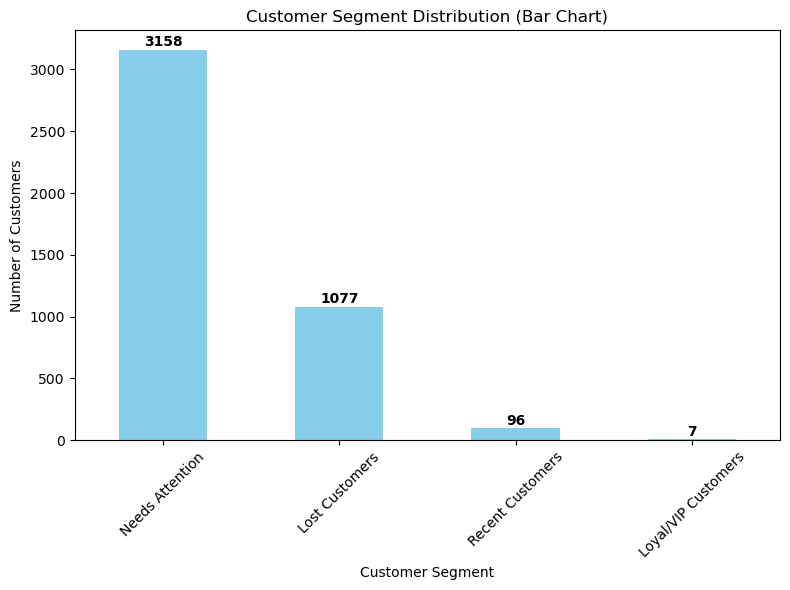

In [81]:
import matplotlib.pyplot as plt

# Count customers per segment
segment_counts = rfm['Segment'].value_counts()

# Plot bar chart
plt.figure(figsize=(8, 6))
bars = segment_counts.plot(kind='bar', color='skyblue')

# Add title and labels
plt.title('Customer Segment Distribution (Bar Chart)')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)

# Add data labels above each bar
for i, count in enumerate(segment_counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()
